## Day Cloud Phase Distinction
This product was developed for use by NWS forecasters in the AWIPS II system as a way to identify the phase (and derive some information of height) of clouds visible from the GOES-16 satellite. The recipe I used is found in this quick guide: http://rammb.cira.colostate.edu/training/visit/quick_guides/Day_Cloud_Phase_Distinction.pdf

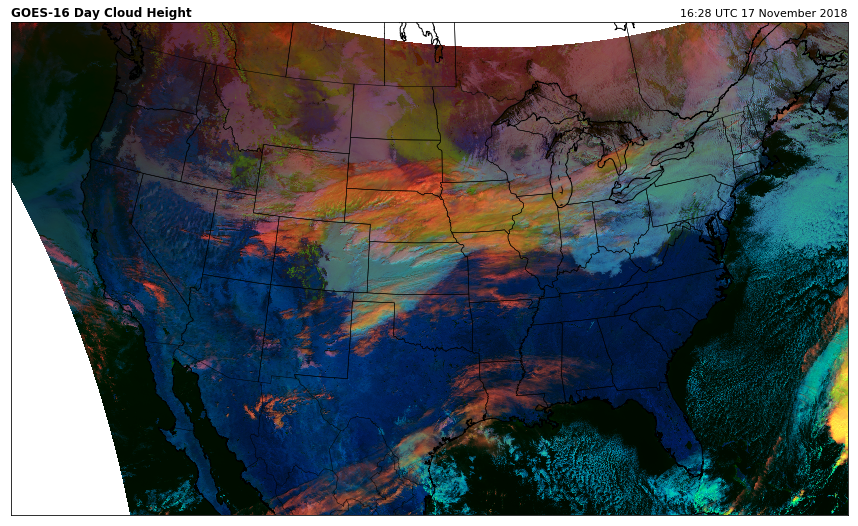

In [2]:
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pyproj import Proj

# Read netcdf file
C_file = '/home/kschneider/Downloads/OR_ABI-L2-MCMIPC-M3_G16_s20183211627149_e20183211629522_c20183211630029.nc'
C = Dataset(C_file, 'r')

# Get date and time
add_seconds = C.variables['t'][0] # Number of seconds since year 2000
add_seconds=int(add_seconds)
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Load the RGB arrays
R = C.variables['CMI_C13'][:] # IR Band 13
G = C.variables['CMI_C02'][:] # "Red" Band 2 visible
B = C.variables['CMI_C05'][:] # "Snow/Ice" Band 5

# Apply range limits for each channel 
G = np.clip(G, 0, .78) # These are albedo (range from 0 to 1)
B = np.clip(B, .01, .59)
# Normalize between 0 and 1
G = (G-0)/(.78-0)
B = (B-.01)/(0.59--0.01)
# Range limits for IR channel
Rmin=219.65 # Kelvin
Rmax=280.65
R = np.clip(R, Rmin, Rmax)
R = (R-Rmin)/(Rmax-Rmin) # Normalize between the range
R = 1. - R # Make cold brightness temperatures appear red

# The final RGB array 
RGB = np.dstack([R,G,B])

# Satellite height, lon, sweep
sat_h = C.variables['goes_imager_projection'].perspective_point_height
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates 
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)
# Important: convert points where R is masked to be a point in the gulf of alaska
lats[R.mask] = 57
lons[R.mask] = -152

# Make a new map object for the CONUS
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:]
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel plots faster

# Plot the image
plt.figure(figsize=[15,12])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)
mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 Day Cloud Height', fontweight='semibold', fontsize=12, loc='left')
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
plt.show()

Red colors in the above image correspond to cold ice clouds or cold land, as the red component comes from the clean IR channel, reversed. Thus, regions with cold brightness temperatures will have a large red component. The green component comes from the visible band, and the blue component comes from the snow/ice band. Both of these bands are albedoes, as opposed to brightness temperatures. Thus, blue colors will correspond to bare land and liquid clouds, as snow and ice are not reflective in the snow/ice band. Greens/yellows indicate the presence of snow cover or mixed-phase clouds, while whiteish-blue colors correspond to primarily warm, liquid clouds.

It's also important to keep in mind that this is a day-only product, as both the visible band and snow/ice band will be zero at night. Additionally, this product may struggle in winter, when snow cover/land may have similar temperatures to ice clouds.